# DSCI 100 Project Final Report - Group 15

## Using Player Behavioural Data to Predict Newsletter Subscriptions

Chloe Bayley, Ray Wu, William Tees-DeBeyer


## Introduction

For this data science project, a Computer Science research group at UBC, led by Frank Wood, has set up a Minecraft (a popular video game) server to collect data on player behaviour to study how people play video games. In particular, the researchers collected data on the players' ages, gender, experience level, subscription status to the game-related newsletter, and the total number of hours played on the server. This led us to question: **Can the age, playtime, gender and experience of a user be used to predict whether or not they will subscribe to a game-related newsletter?**

To explore this question, we will be using the players.csv dataeset, which contains the following variables: 
- experience (**Predictor Variable**): character variable that describes the experience level of a user.
- subscribe (**Response Variable**): logical variable that describes whether that user is subscribed to the newsletter (TRUE) or not (FALSE).
- hashedEmail: encrypted email of the user.
- played_hours (**Predictor Variable**): the total number of hours the user has on the MineCraft server.
- name: name of the user
- gender: categorical variable describing the gender of the user
- Age (**Predictor Variable**): numerical variable describing the age of the user.

**Note**: For this project, hashedEmail and names are not relevant variables, and will be filtered out.

In [41]:
# Libraries used/ Run before everything else!
library(tidyverse)
library(repr)
library(tidymodels)
library(RColorBrewer)

**Methods and Results**

We first tidied our data by removing unessecary columns to our anaylsis; hashed_email and name. 
The next step was to turn categorical variables to numerical. for the experience column, this was done following the natural order of the categories (beginner = 0, amateur = 1, regular = 2, veteran = 3 and pro = 4). Gender was separated into male and non-male because the other gender categories had very little data and a followed a similar trend. The Age and hours played columns are already numerical so no change was necessary. The outcome variable is the subscribe column, and thus, should be turned into a factor type variable, where TRUE was changes to "Subscribed" and False, to "Not Subscribed."


We then created a recipe with subscribe as the as the outcome, and played_hours, Age and Experience as the predictors. 
The scaling and normalizing step ensures all data is standaridized for the Euclidean distance calculation. 

We performed a singluar split as the dataset is relatively small, with the initial split splitting the data into 80% training data and 20% testing.

Following this, we set up the KNN classifcation model with the training data, and neighbors as tune() to find the optimal K value for this dataset. Additionally, due to the smaller dataset, we believe that 3 folds should used find the optimal K-value as it ensures the folds are larger have larger validation sets.

In [2]:
#reads data 
players_data <- read.csv("players.csv")

Firstly, the code above reads the comma-separated dataset, players.csv, into R as an object named players_data.

In [3]:
#wrangling
players_data_wrangled <- players_data |>
    select(-hashedEmail, -name) |>
    mutate(gender = ifelse(gender == "Male", "Male", "Non-Male")) |>
    mutate(experience = case_when(
        experience == "Beginner" ~ 0,
        experience == "Amateur" ~ 1,
        experience == "Regular" ~ 2,
        experience == "Veteran" ~ 3,
        experience == "Pro" ~ 4,
    )) |>
    mutate(subscribe = as.factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Subscribed" = "TRUE", "Not Subscribed" = "FALSE")) |>
    filter(Age != "NA")

head(players_data_wrangled)

,experience,subscribe,played_hours,gender,Age
,<dbl>,<fct>,<dbl>,<chr>,<int>
1,4,Subscribed,30.3,Male,9
2,3,Subscribed,3.8,Male,17
3,3,Not Subscribed,0.0,Male,17
4,1,Subscribed,0.7,Non-Male,21
5,2,Subscribed,0.1,Male,21
6,1,Subscribed,0.0,Non-Male,17


This data is then wrangled. First, the hashedEmail and name variables are removed from the dataset using select(), as they do not have predictive value and are not relevant to the analysis. Following this, mutate() and ifelse() functions are used in conjunction to mutate the gender variables, such that all of the genders are categorized into either Male, or Non-Male. Additionally, 2 users did not input an age, so they were filtered out so that we can effectively use age as a predictor. Finally, the case_when() function is used to mutate the character variables of experience into numerical values, allowing us to use it as a predictor for KNN classification.

### Summary

We can see our data is tidy, every row an observation, every coloumn a variable, and every cell is filled (except for some NA's in Age). There are 196 players in total.

We have seven variables: "experience" "subscribe" "hashedEmail" "played_hours" "name" "gender" "Age"

-Experience is a class with a range of "Beginner, Amateur, Regular, Veteren, Pro"

-Subscribe is a boolean (True or False) that shows if they have subscribed to a game-related newsletter or not, this is our main predicitive focus.

-HashedEmail is a character string that shows an encoded identifier, no useful for us but essential if contact with the person is needed.

-Played hours is a dbl, a decimal number with one decimal of precision, and is how many hours were played on the study's server.

-Name is a character string and is the first name of the person.

-Gender is also a character string and is the gender of the person, we will treat it as a class, Male and Other.

-Age is a dbl but has no decimal places in the data and is treated as an integer, it is the age of the person.


In [65]:
#exploratory visualization/graphs

options(repr.plot.width = 13)

#Plotting experience versus subscriptions
exp_experience_plot <- players_data_wrangled |>
    ggplot(aes(x = experience, fill = subscribe)) +
    geom_bar() +
    labs(x = "Experience (Class)", y = "Number of Users", fill = "Newsletter Subscription",
         title = "Figure 1", subtitle = "Distribution of Experience Levels by Subscription Status") +
    theme(plot.title = element_text(face = "bold", size = 15),
         plot.subtitle = element_text(size = 15),
         text = element_text(size = 15))

#Plotting playtime versus subscriptions
exp_playtime_plot <- players_data_wrangled|>
  ggplot(aes(x = played_hours, fill = subscribe)) +
  geom_histogram(binwidth = 5) +
    labs(x = "Playtime (Hours/ Grouped by 5)", y = "Number of Users", fill = "Newsletter Subscription",
         title = "Figure 2", subtitle = "Distribution of User Playtime by Subscription Status") +
    theme(plot.title = element_text(face = "bold", size = 15),
         plot.subtitle = element_text(size = 15),
         text = element_text(size = 15))


#Plotting gender versus subscriptions
exp_gender_plot <- players_data_wrangled|>
    ggplot(aes(x = gender, fill = subscribe)) +
    geom_bar() +
    labs(x = "Gender", y = "Number of Users", fill = "Newsletter Subscription",
         title = "Figure 3", subtitle = "Distribution of Gender by Subscription Status") +
    theme(plot.title = element_text(face = "bold", size = 15),
         plot.subtitle = element_text(size = 15),
         text = element_text(size = 15))

#Plotting Age versus subscriptions
age_plot <- players_data_wrangled|>
    ggplot(aes(x = Age, fill = subscribe)) +
    geom_histogram(binwidth = 1) + 
    labs(x = "Age (years)", y = "Number of Users", fill = "Newsletter Subscription",
         title = "Figure 4", subtitle = "Distribution of Age by Subscription Status") +
    theme(plot.title = element_text(face = "bold", size = 15),
         plot.subtitle = element_text(size = 15),
         text = element_text(size = 15)) 


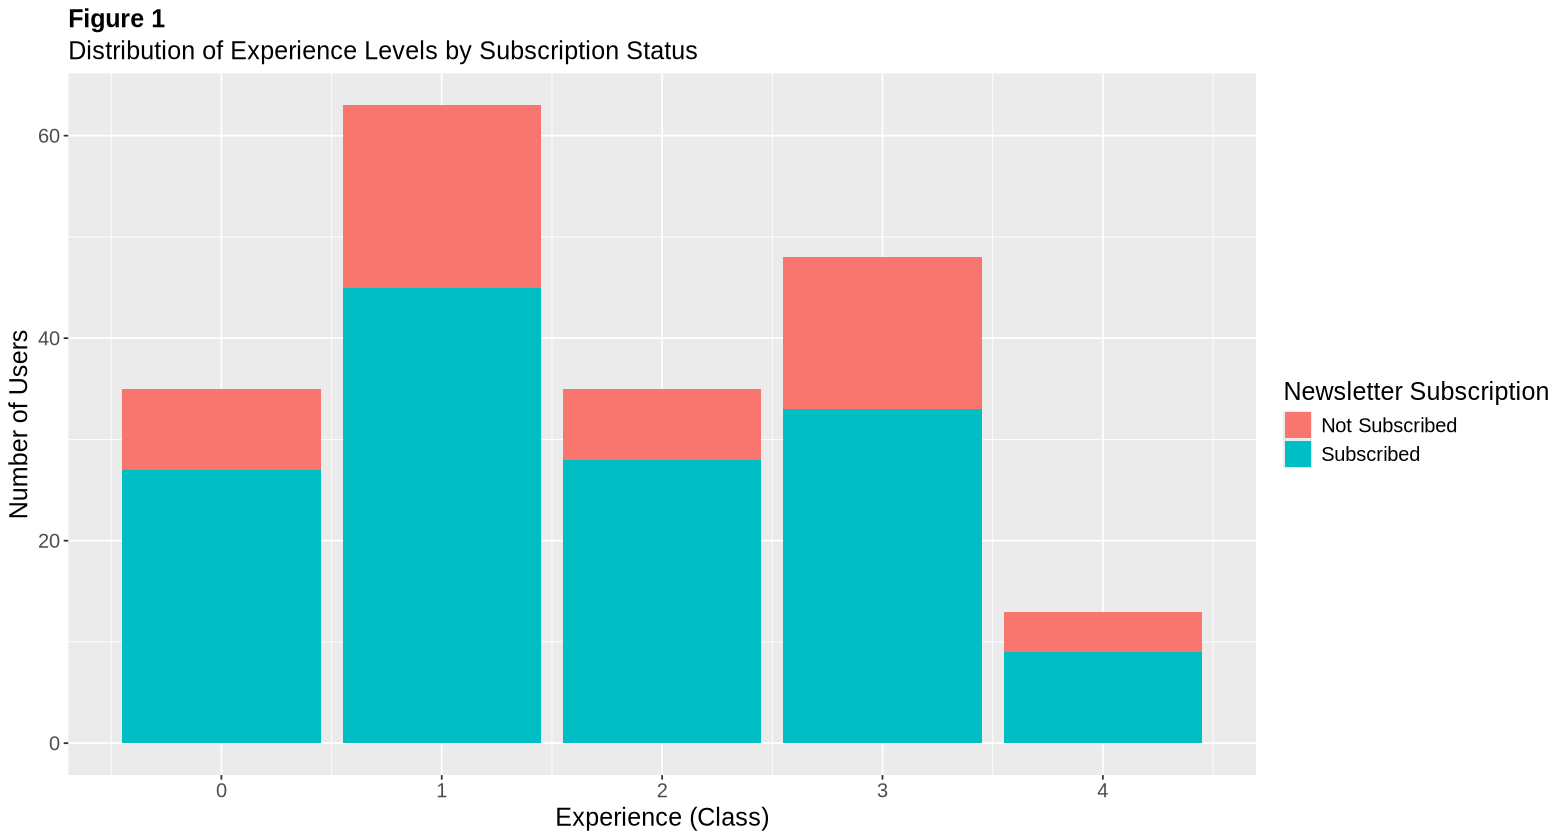

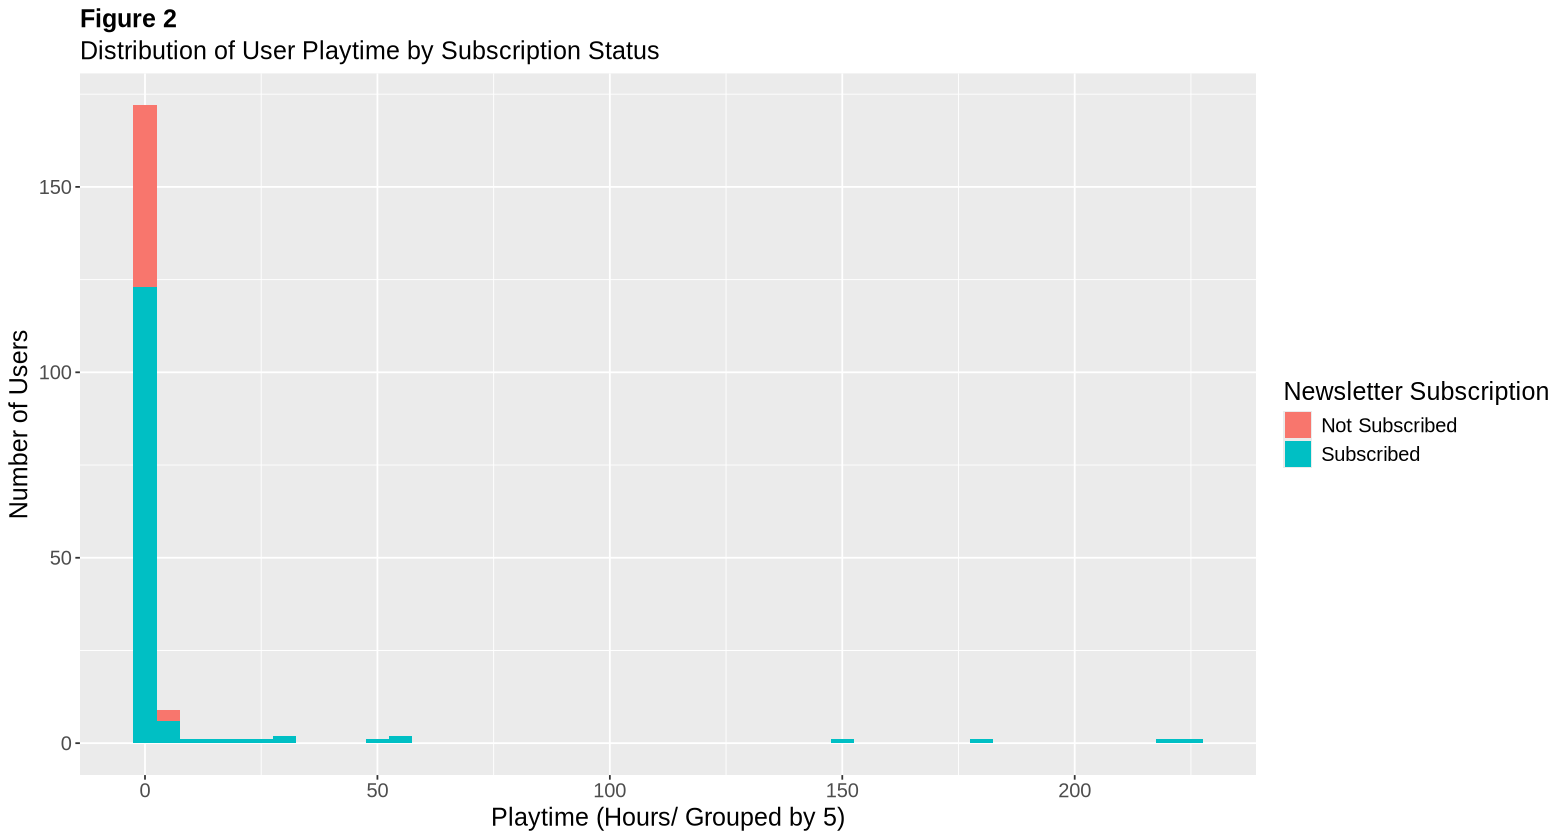

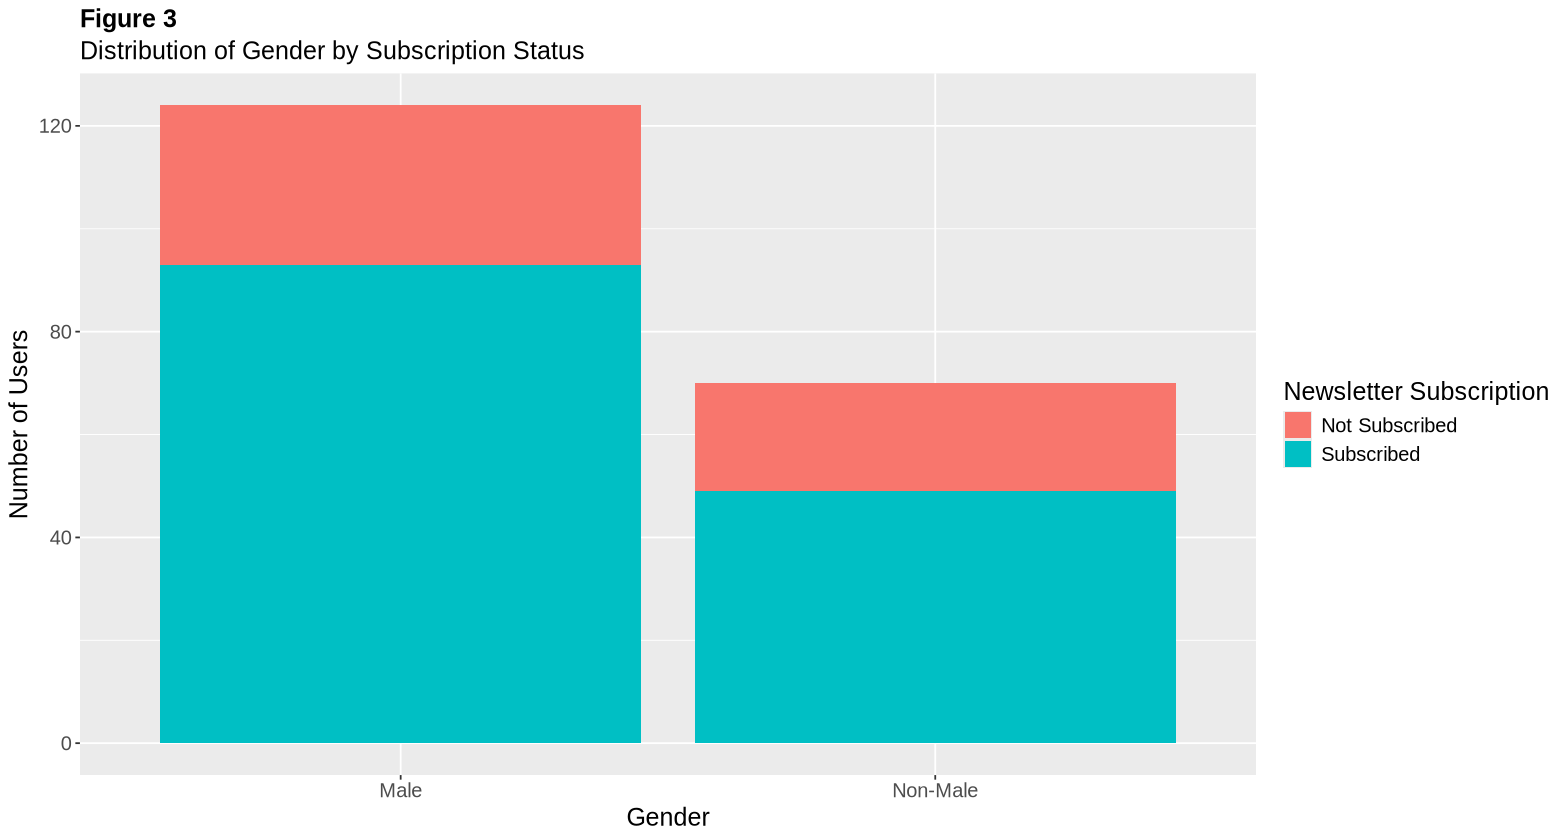

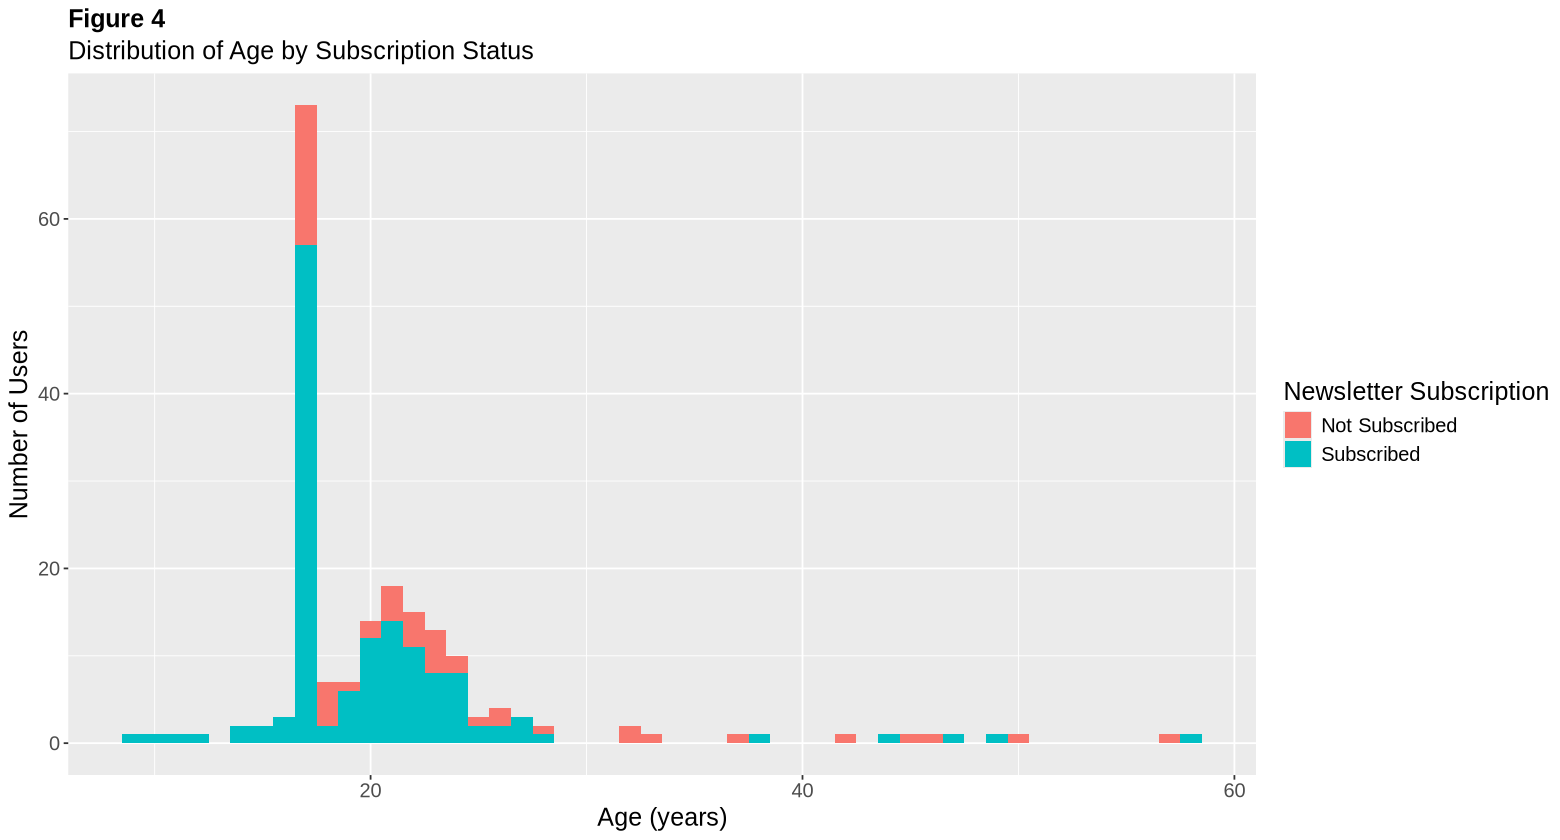

In [66]:
#Plotting the graphs
exp_experience_plot
exp_playtime_plot
exp_gender_plot
age_plot

From Figure 1, we can see that across all five experience levels there are fractions of subscribed users and non-subscribed users. In particular, for experience levels 0 (Beginner), 2 (Regular) and 4 (Pro), there appears to be a larger fraction of subscribed users to non-subscribed users, suggesting that players of these experience levels are more likely to subscribe. These results are a bit unexpected because we had thought that inexperienced and pro players would be the majority subscribed users, because inexperienced players may look towards the newletters for help, and pro players would help newer players. As a result, it seems that experience level can be used as an indicator for the model.

Secondly, from Figure 2 it is seen that the majority of players have a total playtime of 0-5 hours, and most of those players are already subscribed. However, all players with a playtime of over 10 hours are subscribed to the newsletter, suggesting that players who play more are more likely to subscribed, thus highlighting how total playtime can be used as a predictor for newsletter subscription. This was expected because total-played hours is a good indicator of how dedicated a user might be, such that dedicated users are more likely to participate in the community (the newsletters).

Moreover, from Figure 3, we can see that ~3/4 of male users are subscribed to the newsletter, where a similar trend is also seen for non-male users. This suggests that gender does not have a significant correlation to newsletter subscriptions and that it would be a weak predictor. Therefore, the gender variable will not be included in the predictive KNN model. This was fairly expected because we don't see why gender would affect subscription status.

Finally, from Figure 4, we cna see that the modal age of users is 16 years old, and that the majority of subscribed users are within the age range of 15-25 years old. For users over the age of 30, it is seen that most of these users are not-subscribed, suggesting that older players do not subscribe to game-related newsletters. This was somewhat expected, because older users typically use the internet less than teenagers, and by extension, would be more likely to be unaware of the newsletter's existence. Because of this, age appears to be a useful predictor, and will be included in the KNN classification model.

In [30]:
#analysis
set.seed(12345) #Do not change

#First split; 80% training, 20% testing
players_initial_split <- initial_split(players_data_wrangled, prop = 0.8, strata = subscribe)

players_testing <- testing(players_initial_split)
players_training <- training(players_initial_split)


#Selecting K by tuning
#recipe for tuning
players_recipe <- recipe(subscribe ~ experience + Age + played_hours, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

#model specification for tuning
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#K values to test
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

#3 folds
players_vfold_3 <- vfold_cv(players_training, v = 3, repeats = 3, strata = subscribe)

#Metrics for evaluation
vfold_metrics_3 <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_tune) |>
    tune_grid(resamples = players_vfold_3, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    select(neighbors, mean)

vfold_visual <- ggplot(vfold_metrics_3, aes(x = neighbors, y = mean)) +
#Shows the the optimal K is roughly 11-12. We will be selecting 12 as our K.
    geom_point() + 
    geom_line() +
    labs(x = "Number of Neighbors", y = "Estimated Accuracy", 
         title = "Figure 5", subtitle = "Accuracy estimate versus number of neighbors") +
    theme(plot.title = element_text(face = "bold", size = 15),
         plot.subtitle = element_text(size = 15),
         text = element_text(size = 15)) 

#Now that we have optimized our parameters, a new model specification with K = 12 can be made, finishing our optimized model.
knn_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = 12) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_tuned) |>
    fit(players_training)

knn_predict <- predict(knn_fit, players_testing) |>
    bind_cols(players_testing) 

knn_accuracy <- knn_predict |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

event_levels <- knn_predict |> pull(subscribe) |> levels()
#"Not Subcribed" is event level 1 and "Subscribed" is event level 2. 
#Thus, truth will be event level 2 because we are looking for subscribed players

#recall stats
knn_recall <- knn_predict |> recall(truth = subscribe, estimate = .pred_class, event_level = "second")

#precision stats
knn_precision <- knn_predict |> precision(truth = subscribe, estimate = .pred_class, event_level = "second")

#combined stats
eval_metrics <- bind_rows(knn_accuracy, knn_recall, knn_precision)

#confusion matrix
confusion_matrix <- knn_predict |>
    conf_mat(truth = subscribe, estimate = .pred_class)

To analyze the data we first began by setting our seed (set.seed(12345)) to make our results reproducible, particularly the random splits of data. We then split our main dataset into 80% training and 20% testing using the "initial_split" function; as the dataset is relatively small, we believed that the 80/20 split would give us enough data to create a reasonable classification model, whilst still having data left over to test performance.

To select the best K amount of neighbours, we first created a recipe object, which specifies that we are using the "experience," "Age," and "played_hours" variables as predictors to predict the "subscribe" variable. As these predictors are numerical and operate on different scales and ranges, all predictors were scaled and centered to ensure each variable contributes equally to distance calculations. Furthermore, for our model specifications, we chose KNN classification using euclidean distance calculations (weight_func = "rectangular"), as well as tune() for our number of neighbors, allowing us to first determing the best K before creating the final model. Again, due to the smaller size of the dataset, we deemed K-values from 1-20 to be reasonable and chose 3 folds to ensure there is a reasonable amount of data in each fold. Finally, the recipe and model were combined in a workflow, and tune_grid was used to evaluate the model performance at each K and the results were summarized in Figure 4, which plots the accuracy of the model at each K. To which, we determined that the optimal K to use would be 12 neighbors as the improvements to accruacy fall off around K = 12.

With these results in mind, we repeated the process by creating a new model specification with K = 12, rather than tune(), and combined the old recipe with the new specification "knn_spec" into a workflow and fitted the data to the training set. After this, we used the model to classify whether users in the testing set were subscribed or not, and the performance metrics of our final model was extracted using the metrics(), recall() and precision() functions, and combined into a single table for readability. Finally, a confusion matrix was also generated to evaluate model performance.

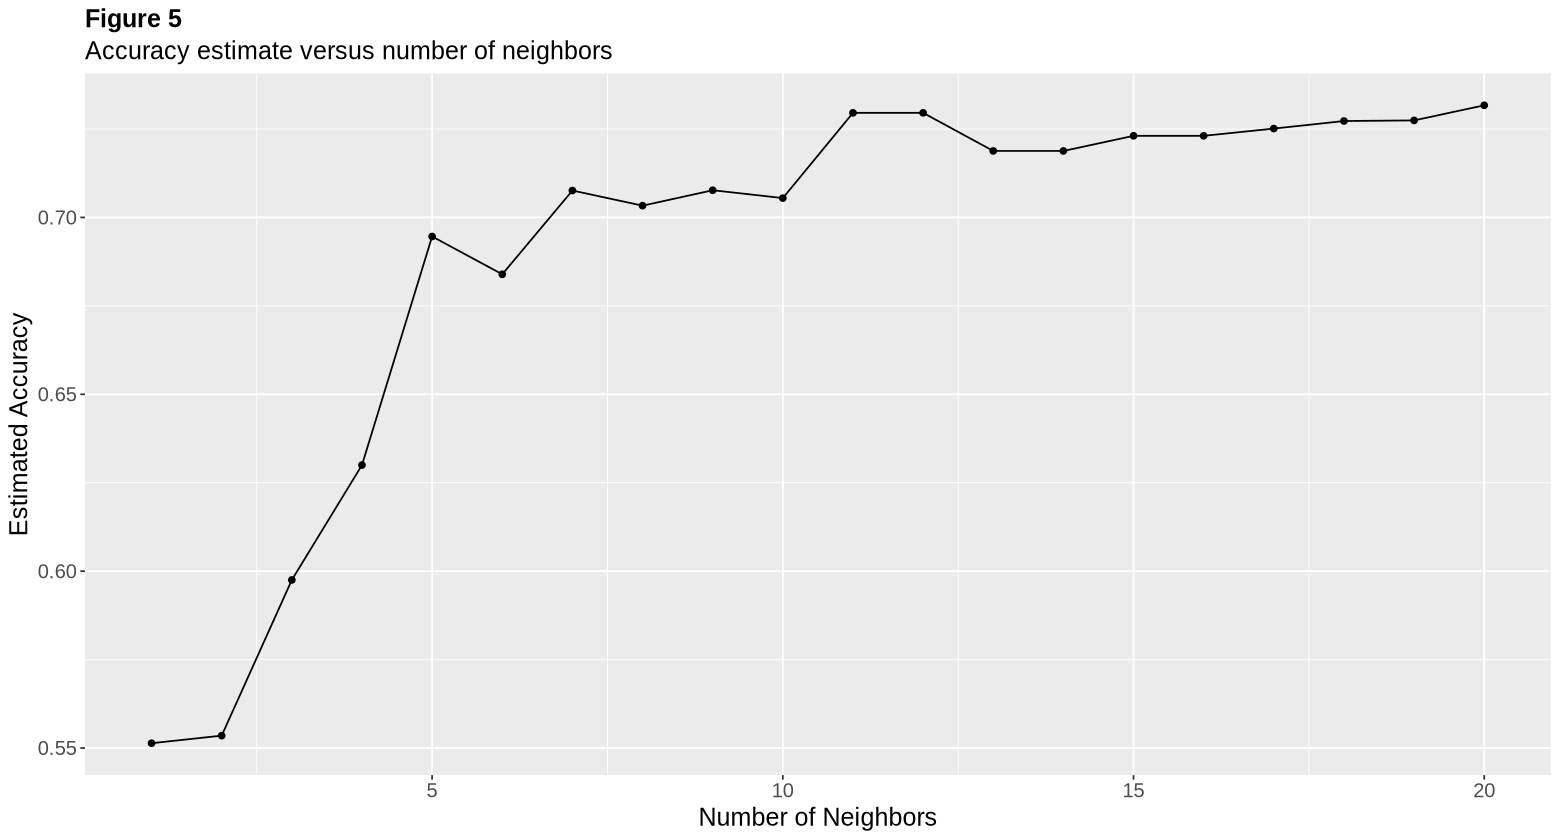

In [31]:
#visualization of analysis
#plots estimated accuracy vs neighbors
vfold_visual

In [8]:
#model evaluation table
eval_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7250000
recall,binary,0.9655172
precision,binary,0.7368421


In [9]:
#confusion matrix
confusion_matrix

                Truth
Prediction       Not Subscribed Subscribed
  Not Subscribed              1          1
  Subscribed                 10         28

### Discussion

- Comment on Accuracy of the model

- Comment on the recall
    Recall might be high because the model is predicting almost everything as subscribed, and getting it right because most of the data is subscribed.

- Comment on the precision

- Others

#### References

Nelamali, Naveen. (2024, May 27). R ifelse() Usage with Examples. Spark By. https://sparkbyexamples.com/r-programming/r-ifelse/

**CITE** https://www.datanovia.com/en/blog/ggplot-title-subtitle-and-caption/#google_vignette
